In [1]:
import pathlib
import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from functools import partial
from matplotlib import cm


def process_run(run):
    with run.open('r') as fin:
        training = []
        final_metrics = {}
        hparams = next(fin)
        while 1:
            try:
                duplet = []
                for _ in range(2):
                    duplet.append(json.loads(next(fin)))
                # FINAL LINES:
                if duplet[0].get('positional_disent'):
                    final_metrics['ood_possim'] = duplet[1]["positional_disent"]
                    final_metrics['ood_bossim'] = duplet[1]["bag_of_symbol_disent"]
                    final_metrics['ood_topsim'] = duplet[1]["topographic_sim"]
                    break
                # TRAINING PROGRESS:
                training.append(dict(
                    ood_acc=duplet[0]['generalization hold out']['acc'],
                    ind_acc=duplet[0]['uniform holdout']['acc'],
                    train_acc=duplet[1]['acc'],
                ))
            except StopIteration:
                # UNFINISHED TRAINING:
                break
        return training, final_metrics
    
def _process_exp(fpath, n_epochs, n_runs):
    runs = fpath.glob('*')
    @dataclass
    class ExpRes:
        ood_acc: np.array = np.zeros((n_runs, n_epochs), dtype=np.float)
        ind_acc: np.array = np.zeros((n_runs, n_epochs), dtype=np.float)
        train_acc: np.array = np.zeros((n_runs, n_epochs), dtype=np.float)
        ood_possim: np.array = np.zeros((n_runs,), dtype=np.float)
        ood_bossim: np.array = np.zeros((n_runs,), dtype=np.float)
        ood_topsim: np.array = np.zeros((n_runs,), dtype=np.float)
    
    expres = ExpRes()
    for run_id, r in enumerate(runs):
        res_trn, res_finalmetrics = process_run(r)
        for row_id, row in enumerate(res_trn):
            for k, v in row.items():
                getattr(expres, k)[run_id, row_id] = v
                    
        # fill in remaining epochs with last value:
        for r_id in range(row_id + 1, n_epochs):
            for k, v in row.items():
                getattr(expres, k)[run_id, r_id] = v 

        if res_finalmetrics:
            for k, v in res_finalmetrics.items():
                getattr(expres, k)[run_id] = v
    return expres


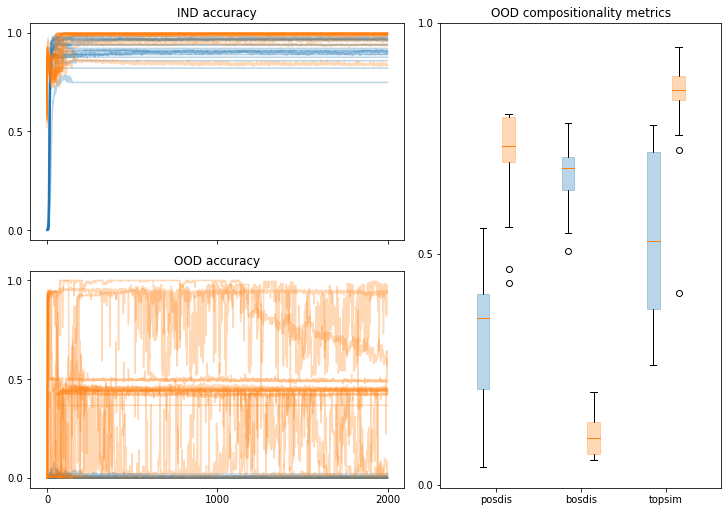

In [2]:
%matplotlib inline

results_root = './results/'
colormap = cm.get_cmap('tab10')
plt.rcParams['figure.figsize'] = [25, 4]

N_EPOCHS = 2000
N_RUNS = 20


mamaexpnames = [
    'orig_arch/220520T115546',
    'modified_arch/220517T231916',
]

process_exp = partial(_process_exp, n_epochs=N_EPOCHS, n_runs=N_RUNS)
    
fig, axd = plt.subplot_mosaic([['ind_acc', 'comp'],
                               ['ood_acc', 'comp']],
                              figsize=(10, 7),
                              gridspec_kw=dict(width_ratios=[4, 3]),
                              constrained_layout=True,)

def plot_row(expres, color, axs_row, boxplot_offset=0):
    for col_id, valtype in enumerate(('ind_acc', 'ood_acc')):
        arr = getattr(expres, valtype).T
        axs_row[valtype].plot(arr, color=color, alpha=0.3)

    for position, comp_metric in enumerate(('ood_possim', 'ood_bossim', 'ood_topsim')):
        position += boxplot_offset
        bplot = axs_row['comp'].boxplot(getattr(expres, comp_metric), positions=[position], patch_artist=True, boxprops=dict(facecolor=color, color=color, alpha=.3))

offset = 0.3
for model_id, expname in enumerate(mamaexpnames):
    color = colormap(model_id)
    expres = process_exp(pathlib.Path(results_root + expname))
    plot_row(expres, color, axd, boxplot_offset=(model_id*offset)-((2 - 1)*offset)/2)

axd['ind_acc'].set(title='IND accuracy', xticks=[0, 1000, 2000], xticklabels=[], yticks=[0, 0.5, 1]) #_title('IND acc')
axd['ood_acc'].set(title='OOD accuracy', xticks=[0, 1000, 2000], yticks=[0, 0.5, 1])
axd['comp'].set(title='OOD compositionality metrics', xticks=[0, 1, 2], xticklabels=['posdis', 'bosdis', 'topsim'], yticks=[0, 0.5, 1]); #_title('IND acc') .set_title('OOD compositionality measures')

# plt.savefig('full_training.pdf')

In [3]:
# LATEX FORMATTING
def print_row(run_name, expres):
    s = run_name
    for col_id, valtype in enumerate(('train_acc', 'ind_acc', 'ood_acc', 'ood_possim', 'ood_bossim', 'ood_topsim')):
        arr = getattr(expres, valtype).T
        s += f" & ${arr.mean():.2f} \pm {arr.std():.2f}$"
    print(s + r" \\")

expres = process_exp(pathlib.Path(results_root + "orig_arch/220520T115546"))
print_row("\citep{Chaabouni20}  ", expres)
expres = process_exp(pathlib.Path(results_root + "modified_arch/220517T231916"))
print_row("ours                 ", expres)

\citep{Chaabouni20}   & $0.99 \pm 0.07$ & $0.91 \pm 0.09$ & $0.00 \pm 0.01$ & $0.32 \pm 0.15$ & $0.67 \pm 0.07$ & $0.53 \pm 0.18$ \\
ours                  & $0.99 \pm 0.03$ & $0.98 \pm 0.05$ & $0.42 \pm 0.27$ & $0.71 \pm 0.11$ & $0.11 \pm 0.04$ & $0.83 \pm 0.11$ \\
